--- Visualizing inception_v3 ---
Loading Supervised (ImageNet) model...
Loading Self-Supervised model...
Self-Supervised model loaded successfully (Head layers ignored).


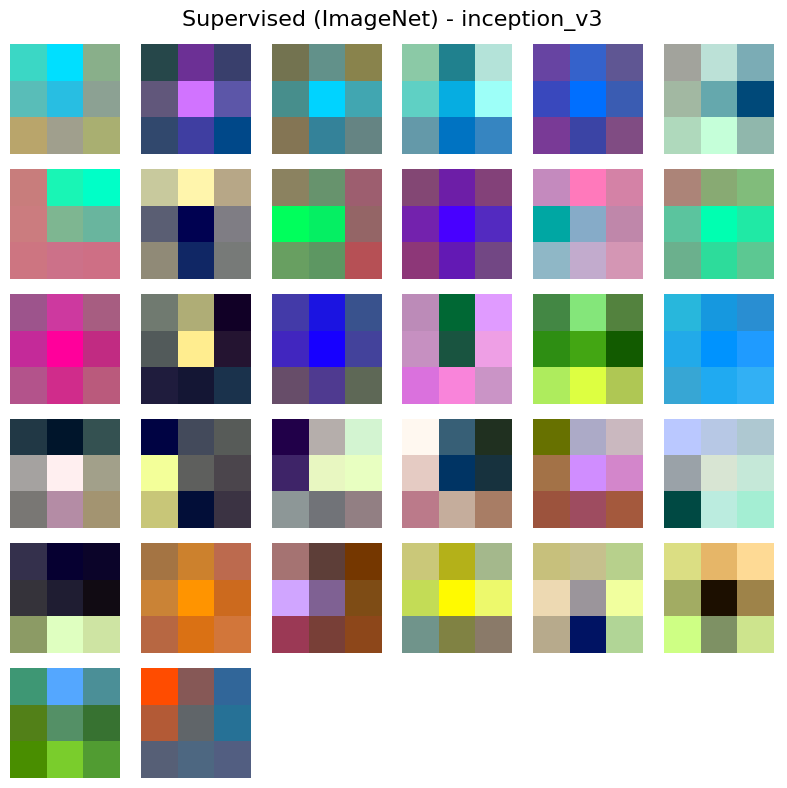

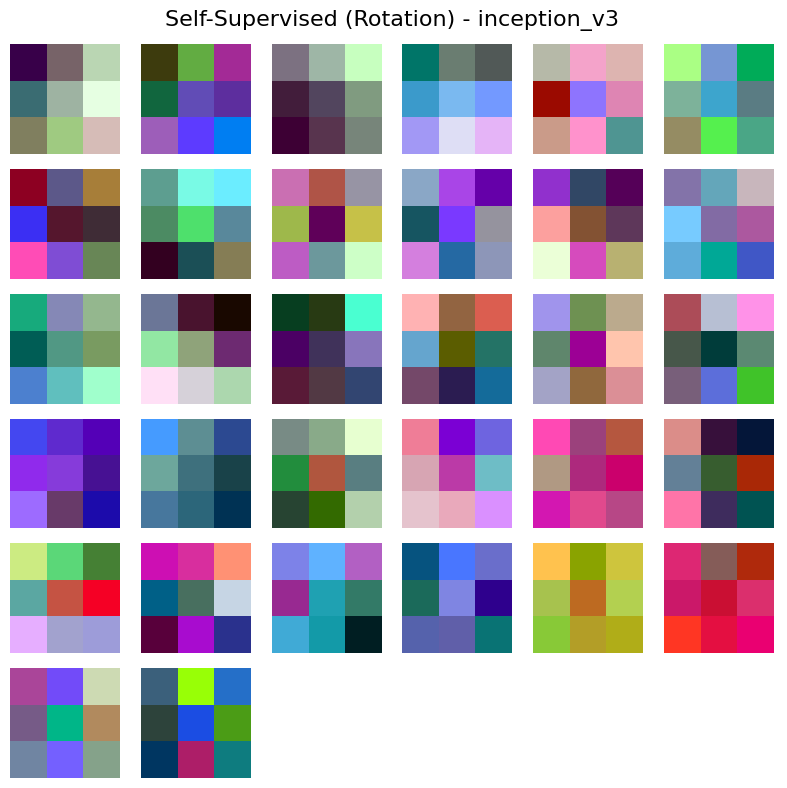

In [10]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import math

# --- 1. HELPER FUNCTIONS ---

def get_first_layer_weights(model, model_name):
    """
    Extracts the weights of the first convolutional layer based on the architecture.
    """
    if 'resnet' in model_name:
        return model.conv1.weight.data.cpu()
    
    elif 'inception' in model_name:
        return model.Conv2d_1a_3x3.conv.weight.data.cpu()
    
    elif 'efficientnet' in model_name:
        # EfficientNet first conv is inside 'features' block 0, layer 0
        return model.features[0][0].weight.data.cpu()
    
    else:
        raise ValueError(f"Architecture for {model_name} not implemented.")

def normalize_filters(weights):
    """
    Normalizes weights to 0-1 range for visualization.
    """
    w = weights.clone()
    # Min-max normalization per kernel
    min_val = w.view(w.size(0), -1).min(dim=1)[0].view(-1, 1, 1, 1)
    max_val = w.view(w.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    w = (w - min_val) / (max_val - min_val)
    return w

def plot_kernels(weights, title="Kernels"):
    """
    Plots a grid of kernels.
    """
    num_kernels = weights.shape[0]
    # Limit to 64 kernels for visibility (EfficientNet usually has 32 in layer 1)
    num_kernels = min(num_kernels, 64) 
    
    grid_size = math.ceil(math.sqrt(num_kernels))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            # Transpose (C, H, W) -> (H, W, C) for matplotlib
            img = weights[i].numpy().transpose(1, 2, 0)
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

# --- 2. MAIN CONFIGURATION ---

# Define architectures
architectures = {
    'resnet18': models.resnet18,
    'resnet50': models.resnet50,
    'inception_v3': models.inception_v3,
    'efficientnet_b0': models.efficientnet_b0,
    'efficientnet_b3': models.efficientnet_b3
}

# SETTINGS
target_arch = 'inception_v3'  
path_to_your_model = 'model_saving/fullTraining_inception_v3.pth'  

print(f"--- Visualizing {target_arch} ---")

# --- 3. LOAD SUPERVISED MODEL (BASELINE) ---
print("Loading Supervised (ImageNet) model...")
supervised_model = architectures[target_arch](weights='DEFAULT')
sup_weights = get_first_layer_weights(supervised_model, target_arch)
norm_sup_weights = normalize_filters(sup_weights)


# --- 4. LOAD YOUR SELF-SUPERVISED MODEL ---
print("Loading Self-Supervised model...")
my_model = architectures[target_arch](weights=None) 

# Load the file
state_dict = torch.load(path_to_your_model, map_location='cpu')

# A. Fix DataParallel 'module.' prefix (if present)
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# B. FILTERING STEP (Crucial for EfficientNet)
# Remove 'classifier' keys to avoid size mismatch errors
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
if 'fc.weight' in state_dict: # Also filter 'fc' if you used ResNet logic previously
     filtered_state_dict = {k: v for k, v in filtered_state_dict.items() if not k.startswith('fc')}

# C. Load weights
my_model.load_state_dict(filtered_state_dict, strict=False)
print("Self-Supervised model loaded successfully (Head layers ignored).")

my_weights = get_first_layer_weights(my_model, target_arch)
norm_my_weights = normalize_filters(my_weights)

# --- 5. PLOT RESULTS ---
plot_kernels(norm_sup_weights, title=f"Supervised (ImageNet) - {target_arch}")
plot_kernels(norm_my_weights, title=f"Self-Supervised (Rotation) - {target_arch}")